<a href="https://colab.research.google.com/github/PierreNowi/cs230-project/blob/master/DQN_factor_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deep Q-Learning for factor trading**

Notebook of the Deep Q-Learning structure.
from Github:
* Load the factor signals dataframe 
* Load the valuation dataframe (closing price of stocks)
* Load the dataframe of market informations (stock, interest rates,etc)

1. Build the structure of the networks (in progress)
2. Define the network (in progress)



In [0]:
# Not needed in the current implementatio
#!git clone https://github.com/PierreNowi/cs230-project.git

In [2]:
# insert tensorflow version 2
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 98kB/s 
     |████████████████████████████████| 501kB 51.6MB/s 
     |████████████████████████████████| 3.1MB 41.2MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
# %tensorflow_version 1.x # to ensure version 1.x in tensorflow

2.0.0-beta1


In [66]:
# Collect from GitHub the data  - Load the factor signals dataframe

!wget --no-check-certificate \
    https://raw.githubusercontent.com/PierreNowi/cs230-project/master/Data-factor/data_factor.csv \
    -O /tmp/data_factor.csv
!wget --no-check-certificate \
    https://raw.githubusercontent.com/PierreNowi/cs230-project/master/Data-processed/data_risk.csv \
    -O /tmp/data_risk.csv
!wget --no-check-certificate \
    https://raw.githubusercontent.com/PierreNowi/cs230-project/master/Data-processed/data_content.csv \
    -O /tmp/data_content.csv
!wget --no-check-certificate \
    https://raw.githubusercontent.com/PierreNowi/cs230-project/master/Data-processed/data_list.csv \
    -O /tmp/data_list.csv

--2019-12-17 12:03:40--  https://raw.githubusercontent.com/PierreNowi/cs230-project/master/Data-factor/data_factor.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 705173 (689K) [text/plain]
Saving to: ‘/tmp/data_factor.csv’

/tmp/data_factor.cs 100%[===================>] 688.65K  --.-KB/s    in 0.004s  

2019-12-17 12:03:40 (177 MB/s) - ‘/tmp/data_factor.csv’ saved [705173/705173]

--2019-12-17 12:03:42--  https://raw.githubusercontent.com/PierreNowi/cs230-project/master/Data-processed/data_risk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 

In [0]:
SOURCE_FOLDER = 'tmp'
FACTOR_FOLDER = 'tmp'
TARGET_FOLDER = "tmp"

DESCRIPTION_FILE = "data_list.csv"
DATA_FILE = "data_content.csv"
RISK_FILE = "data_risk.csv"
FACTOR_FILE = "data_factor.csv"

INVESTMENT = 10000

In [78]:
# Load the time-series dataset, the static dataset and the risk dataset. 
df_desc = pd.read_csv(
    os.path.join(os.getcwd(),SOURCE_FOLDER, DESCRIPTION_FILE),encoding='utf-8', index_col=0)
df_data = pd.read_csv(
    os.path.join(os.getcwd(),SOURCE_FOLDER, DATA_FILE),encoding='utf-8', index_col=0)
df_risk = pd.read_csv(
    os.path.join(os.getcwd(),SOURCE_FOLDER, RISK_FILE),encoding='utf-8', index_col=0)
# Load the factor dataset
df_factor = pd.read_csv(
    os.path.join(os.getcwd(),FACTOR_FOLDER, FACTOR_FILE),encoding='utf-8', index_col=0)

tmp/data_factor.csv
/tmp/data_content.csv


In [79]:
# Visualisation dataframe description
df_desc.head()

,NAME,SICUR,TYPE
MNEM,,,
PA1436583006,CARNIVAL,NaN,Equity
US22160K1051,COSTCO WHOLESALE,NaN,Equity
US4581401001,INTEL,NaN,Equity
AN8068571086,SCHLUMBERGER,NaN,Equity
NASCOMP,NASDAQ COMPOSITE,NaN,Index


In [83]:
# Visualisation dataframe data - Stock prices and stock financial information, commo, fx etc.
df_data.head()

,PA1436583006-MVC,PA1436583006-P,PA1436583006-PH,PA1436583006-PL,PA1436583006-PO,US22160K1051-MVC,US22160K1051-P,US22160K1051-PH,US22160K1051-PL,US22160K1051-PO,US4581401001-MVC,US4581401001-P,US4581401001-PH,US4581401001-PL,US4581401001-PO,AN8068571086-MVC,AN8068571086-P,AN8068571086-PH,AN8068571086-PL,AN8068571086-PO,PA1436583006-WC01151,PA1436583006-WC02001,PA1436583006-WC02999,PA1436583006-WC03051,PA1436583006-WC03255,PA1436583006-WC05376,PA1436583006-WC08101,PA1436583006-WC08106,PA1436583006-WC08221,PA1436583006-WC08231,PA1436583006-WC08311,PA1436583006-WC08316,PA1436583006-WC18191,US22160K1051-WC01151,US22160K1051-WC02001,US22160K1051-WC02999,US22160K1051-WC03051,US22160K1051-WC03255,US22160K1051-WC05376,US22160K1051-WC08101,...,SPXC.SERIESC-OY,SPXC.SERIESC-VI,SPXC.SERIESC-VM,SPXC.SERIESP-I3,SPXC.SERIESP-O1,SPXC.SERIESP-O3,SPXC.SERIESP-O6,SPXC.SERIESP-OI,SPXC.SERIESP-ON,SPXC.SERIESP-OY,SPXC.SERIESP-VI,SPXC.SERIESP-VM,VIXC.SERIESC-O1,VIXC.SERIESC-O3,VIXC.SERIESC-O6,VIXC.SERIESC-OI,VIXC.SERIESC-ON,VIXC.SERIESC-OY,VIXC.SERIESC-VI,VIXC.SERIESC-VM,VIXC.SERIESP-O1,VIXC.SERIESP-O3,VIXC.SERIESP-O6,VIXC.SERIESP-OI,VIXC.SERIESP-ON,VIXC.SERIESP-OY,VIXC.SERIESP-VI,VIXC.SERIESP-VM,USNAPMNO-ES,USPMNBC.Q-ES,USBSINV.B-ES,USCAPUS.R-ES,USCAPUTLQ-ES,USCNFBUSQ-ES,USCNFCONQ-ES,USCRDCONB-ES,USCSHPM%E-ES,USPENONFO-ES,USUMINM1R-ES,ECSWF1Y-IR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,33610.74,39.82,40.25,39.750,39.91,16637.42,36.32,37.420,36.18,37.19,210068.9,32.16,32.600,32.03,32.36,32027.91,27.330,27.550,27.230,27.360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5781
2004-01-05,34121.62,40.43,40.61,40.185,40.28,16559.55,36.15,36.610,35.86,36.44,214967.9,32.91,32.970,32.40,32.52,32525.97,27.755,27.780,26.990,27.100,812000.0,660000.0,27636000.0,1662000.0,7953000.0,400000.0,0.21,0.34,33.54,50.46,27.79,22.44,2185000.0,440721.0,2688638.0,15085793.0,327189.0,1320935.0,92137.0,0.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5938
2004-01-06,34297.64,40.75,40.80,40.300,40.43,16747.36,36.56,36.930,36.06,36.10,214902.7,32.90,33.000,32.62,32.92,32174.39,27.455,27.955,27.275,27.775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5469
2004-01-07,34380.14,40.83,41.00,40.550,40.70,16985.55,37.08,37.175,36.52,36.58,222022.5,33.99,34.000,33.22,33.33,31377.51,26.775,27.330,26.645,27.330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5781
2004-01-08,34754.78,41.24,41.30,40.850,40.87,17068.01,37.26,37.530,37.02,37.40,223655.6,34.24,34.349,33.90,34.17,31553.29,26.925,27.040,26.390,26.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5156


In [81]:
# Visualisation dataframe risk - Closing stock prices for reward evaluation
df_risk.head()

,PA1436583006-P,US22160K1051-P,US4581401001-P,AN8068571086-P
Date,,,,
2004-01-02,39.82,36.32,32.16,27.330
2004-01-05,40.43,36.15,32.91,27.755
2004-01-06,40.75,36.56,32.90,27.455
2004-01-07,40.83,37.08,33.99,26.775
2004-01-08,41.24,37.26,34.24,26.925


In [82]:
# Visualisation dataframe factor - trigger for factor investing
df_factor.head()

,PA1436583006-DIVMOM,US22160K1051-DIVMOM,US4581401001-DIVMOM,AN8068571086-DIVMOM,PA1436583006-EBITDA2EV,US22160K1051-EBITDA2EV,US4581401001-EBITDA2EV,AN8068571086-EBITDA2EV,PA1436583006-SLW,US22160K1051-SLW,US4581401001-SLW,AN8068571086-SLW,PA1436583006-FST,US22160K1051-FST,US4581401001-FST,AN8068571086-FST
Date,,,,,,,,,,,,,,,,
2004-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-05,NaN,NaN,NaN,NaN,0.279958,6.438075,2.936817,0.559438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


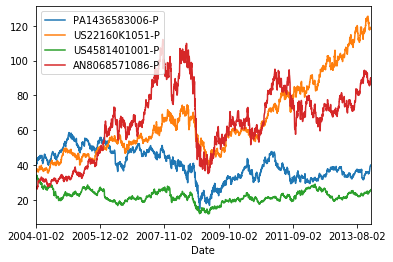

In [85]:
df_risk.plot()



Now we need to define the algorithm itself with the AI_Trader class, here are a few important points:

In trading we have an action space of 3: Buy, Sell, and Sit
We set the experience replay memory to deque with 2000 elements inside it
We create an empty list with inventory which contains the stocks we've already bought
We need to set an gamma parameter to 0.95, which helps to maximize the current reward over the long-term
The epsilon parameter is used to determine whether we should use a random action or to use the model for the action. We start by setting it to 1.0 so that it takes random actions in the beginning when the model is not trained.
Over time we want to decrease the random actions and instead we can mostly use the trained model, so we set epsilon_final to 0.01
We're then set the speed of decreasing epsililon in the epsilon_decay parameter

In [0]:
class AI_Trader():
  
  def __init__(self, state_size, action_space=3, model_name="AITrader"):
    """
    state_size:
    action_space:
    model_name:
    """
    self.state_size
    self.action_space = action_space
    self.memory = deque(2000)
    self.inventory = []
    self.model_name = model.name
    
    self.gammsa = 0.95
    self.epsilon = 1.0
    self.epsilon_final = 0.01
    self.epsilon_decay = 0.995

Defining the Neural Network


In [0]:
def model_builder(self):
      
      model = tf.keras.models.Sequential()
      
      model.add(tf.layers.Dense(units=32, activation='relu', input_dim=self.state_size)
      model.add(tf.layers.Dense(units=64, activation='relu')
      model.add(tf.layers.Dense(units=128, activation='relu')
      model.add(tf.layers.Dense(units=self.action_space, activation='linear')
      model.compile(loss='mse', optimizer=tf.keras.optimizer.Adam(lr=0.001))
  return model

Building a Trading Function

In [0]:
def trade(self, state):
    if random.random() <= self.epsilon:
        return random.randrange(self.action_space)
      
    actions = self.model.predict(actions[0])

Training the Model
Now that we've implemented the trade function let's build a custom training function.

This function will take a batch of saved data and train the model on that, here's how to do that:

We define this function batch_trade and it will take batch_size as an argument
We select data from the experience replay memory by first setting batch to an empty list
We then iterate through the memory with a for loop
Since we're dealing with time series data we need to sample from the end of the memory instead of randomly sampling from it
Now that we have a batch of data we need to iterate through each batch - state, reward, next_state, and done - and train the model with this
If the agent is not in a terminal state we calculate the discounted total reward as the current reward
Next we define the target variable which is also predicted by the model
Next we fit the model with self.model.fit()
At the end of this function we want to decrease the epsilon parameter so that we slowly stop performing random actions

In [0]:
def batch_train(self, batch_size):
  batch = []
  for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
    batch.append(self.memory[i])
    
  for state, action, reward, next_state, done in batch:
    reward = reward
    if not done:
      reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
      
    target = self.model.predict(state)
    target[0][action] = reward
    
    self.model.fit(state, target, epochs=1, verbose=0)
    
  if self.epsilon > self.epsilon_final:
    self.epsilon *= self.epsilon_decay

Stock Market Data Preprocessing
State Creator
Now that we have our dataset_loader function we need to create a function that takes this data and generates states from it.

let's say we have a window_size = 5 so we use 5 states to predict our target, which is a continuous number.

Instead of predicting real numbers for our target we instead want to predict one of our 3 actions.

Next we're going change our input states to be differences in stock prices, which will represent price changes over time.

To implement this in Python we're going to create a function state_creator which takes 3 arguments: data, timestep, and window_size:

We first need to calculate the starting_id
When the starting_id is positive we create a state and if it is negative we append the info until we get to the window_size
Next we define an empty list called state and iterate through the window_data list.
As we append the state we need to normalize the price data with the sigmoid function
To complete the function we return a Numpy array of the state

In [0]:
def state_creator(data, timestep, window_size):
  
  starting_id = timestep - window_size + 1
  
  if starting_id >= 0:
    windowed_data = data[starting_id:timestep+1]
  else:
    windowed_data = starting_id * [data[0]] + list(data[0:timestep+1])
    
  state = []
  for i in range(window_size - 1):
    state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))
    
  return np.array([state])

Training the Q-Learning Trading Agent

The hyperparameters to define include:


In [0]:
window_size = 10
episodes = 1000

batch_size = 32
data_samples = len(data) - 1

trader = AI_Trader(window_size)
trader.model.summary()

Defining a Training Loop
Now we need to train our model, which we're going to do with a for loop that will iterate through all of the episodes.

Next we want to print out the current episode
We then need to define our initial state with state_creator
Then we define 2 variables so that we can keep track of total_profit and we set our inventory to 0 at the beginning of an episode with trader.inventory = []
Next we define our timestep (1 timestep is 1 day) with a for loop, which represents how many samples we have. To do this we need to define our action, next_state, and reward.
Then we want to update our inventory based on the given action
Based on the actions we can calculate our reward and update the total_profit
We then need to check if this is the last sample in our dataset
Next we need to append all of the data to our trader's experience replay buffer with trader.memory.append()
We then change the state to the next_state so we can iterate through the whole episode
Finally we want to print out the total_profit if done = True and add print statements to when we buy or sell and how what the profit is
There are two more things to do before starting the training process:

We need to check if we have more information in our memory than our batch_size. If that is true we call trader.batch_train and pass in the batch_size argument
We're then going to check if the number of episodes is divisible by 10, and if that is the case we're going to save the model with trader.model.save() in an H5 file

In [0]:
for episode in range(1, episodes + 1):
  
  print("Episode: {}/{}".format(episode, episodes))
  
  state = state_creator(data, 0, window_size + 1)
  
  total_profit = 0
  trader.inventory = []
  
  for t in tqdm(range(data_samples)):
    
    action = trader.trade(state)
    
    next_state = state_creator(data, t+1, window_size + 1)
    reward = 0
    
    if action == 1: #Buying
      trader.inventory.append(data[t])
      print("AI Trader bought: ", stocks_price_format(data[t]))
      
    elif action == 2 and len(trader.inventory) > 0: #Selling
      buy_price = trader.inventory.pop(0)
      
      reward = max(data[t] - buy_price, 0)
      total_profit += data[t] - buy_price
      print("AI Trader sold: ", stocks_price_format(data[t]), " Profit: " + stocks_price_format(data[t] - buy_price) )
      
    if t == data_samples - 1:
      done = True
    else:
      done = False
      
    trader.memory.append((state, action, reward, next_state, done))
    
    state = next_state
    
    if done:
      print("########################")
      print("TOTAL PROFIT: {}".format(total_profit))
      print("########################")
    
    if len(trader.memory) > batch_size:
      trader.batch_train(batch_size)
      
  if episode % 10 == 0:
    trader.model.save("ai_trader_{}.h5".format(episode))
    